# **Machine Learning Group Project:** Recommender System Preparation

The purpose of this notebook is to extract content-based similarities across different products on the basis of the plethora of of textual data contained in descriptive columns such as _tags_, _genres_, _description_, or _steamspy_tags_. These findings can later be utilized when building other models.

In [53]:
# General
import requests
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Text Data DataFrame

First we create a DataFrame that contains all instances of descriptive textual data for the products. There is a single entry for each game. We run an inner merge because this is the same kind of merge done between these datasets for the final_df in [a_csv_creation.ipynb](a_csv_creation.ipynb). Consequently, this ensures the data we are working with is compatible with other work later on.

In [4]:
# Import Metadata
df_games_meta_data = pd.read_json('data/games_metadata.json', lines=True)

# Import Games Data
df_games_additional = pd.read_csv("data/steam.csv", 
                                  usecols= ["appid", "name", "genres", "steamspy_tags",
                                           "categories"])

# Merge to a Single DataFrame
textual_df = df_games_additional.join(df_games_meta_data.set_index("app_id"),
                                      on = "appid", how = "inner")

# Show Head
textual_df.head()

,appid,name,categories,genres,steamspy_tags,description,tags
0,10,Counter-Strike,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,Play the world's number 1 online action game. ...,"[Action, FPS, Multiplayer, Shooter, Classic, T..."
1,20,Team Fortress Classic,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,One of the most popular online action games of...,"[Action, FPS, Multiplayer, Classic, Hero Shoot..."
2,30,Day of Defeat,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,Enlist in an intense brand of Axis vs. Allied ...,"[FPS, World War II, Multiplayer, Shooter, Acti..."
3,40,Deathmatch Classic,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,Enjoy fast-paced multiplayer gaming with Death...,"[Action, FPS, Classic, Multiplayer, Shooter, F..."
4,50,Half-Life: Opposing Force,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,Return to the Black Mesa Research Facility as ...,"[FPS, Action, Classic, Sci-fi, Singleplayer, S..."


## Data Preparation

#### Text Homogenization

The first step undertaken is homgenizing the text across the different columns. We do the following:
- Make all words fully lowercase
- Transform the _tags_ column from a list to a string
- Remove separators in the strings of columns such as _categories_, _steamspy_tags_, etc.
- Remove any other punctuation
- Homogenize words with spelling discrepancies (e.g. multiplayer & multi-player)

In [5]:
# Turn to String
textual_df["tags"] = textual_df["tags"].apply(lambda x: str(x))

# Drop the Punctuation
punc = '''!()[]{};:'"\,<>./?@#$%^&*_~'''
 
# Remove punctuation and make everything lowercase with for loop
for i in textual_df["tags"].reset_index()["index"].unique():
    for j in textual_df["tags"][i]:
        if j in punc:
            textual_df.loc[i,"tags"] = textual_df["tags"][i].replace(j, "").lower()

In [6]:
# Use for loop to remove all separators from list columns and turn all to lowercase
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    for j in textual_df.reset_index()["index"].unique():
        textual_df.loc[j, i] = textual_df.loc[j, i].replace(';',' ').lower()
        
        textual_df.loc[j, i] = textual_df.loc[j, i].replace('multi-player', 'multiplayer')\
        .replace("free to play", "free-to-play").replace("singleplayer", "single-player")\
        .replace("post-apocalyptic", "postapocalyptic").replace("scifi", "sci-fi")\
        .replace("anti cheat", "anti-cheat")

In [7]:
# Define numbers
num = '0123456789'

# Remove punctuation, numbers, and turn description to lowercase 
for i in textual_df["description"].reset_index()["index"].unique():
    for j in textual_df["description"][i]:
        
        if j in punc:
            textual_df.loc[i,"description"] = textual_df["description"][i].replace(j, "")
            
        if j in num:
            textual_df.loc[i,"description"] = textual_df["description"][i].replace(j, "")
        
        textual_df.loc[i,"description"] = textual_df["description"][i].lower().replace("multi-player", "multiplayer")

#### Stopword Removal

Although columns like _categories_, _genres_, _steamspy_tags_, and _tags_ do not suffer from this issue, the _description_ column contains stopwords which could be detrimental to our analysis. The stopword list is obtained from a separate [GitHub project](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt).

In [8]:
# Obtain stopwords
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# Remove Stopwords
textual_df['description'] = textual_df['description']\
.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

#### Full Text Column Creation

Finally, we create a new column which contains all the textual information we have on a game.   

In [9]:
# Use for loop to summarize all movie tags into one
for i in textual_df["description"].reset_index()["index"].unique():
    full_txt = ""
    for j in ["categories", "genres", "steamspy_tags", "description", "tags"]:
        full_txt += " " + textual_df.loc[i, j]
        
    textual_df.loc[i, "full_text"] = full_txt[1:]

## Text Data Exploration

In [1]:
# Split and count steamspy_tags and genres
steamspy_tags = final_df['steamspy_tags'].str.split(';', expand=True).stack().value_counts()
genres = final_df['genres'].str.split(';', expand=True).stack().value_counts()

# Print the most common steamspy_tags and genres
print("Most common steamspy_tags:\n", steamspy_tags.head(10))
print("\nMost common genres:\n", genres.head(10))

# Combine the split steamspy_tags and genres back into the DataFrame
final_df['steamspy_tags'] = final_df['steamspy_tags'].str.split(';')
final_df['genres'] = final_df['genres'].str.split(';')

# Calculate game popularity metrics, sales, and price_final
final_df['average_playtime'] = final_df['average_playtime'].astype(float)
final_df['reviews'] = final_df['reviews'].astype(int)
final_df['price_final'] = final_df['price_final'].astype(float)

# Group by steamspy_tags and genres, and calculate the average popularity, sales metrics, and price_final
tags_popularity = final_df.explode('steamspy_tags').groupby('steamspy_tags').agg({
    'average_playtime': 'mean',
    'reviews': 'sum',
    'price_final': 'mean'
}).sort_values('reviews', ascending=False)

genres_popularity = final_df.explode('genres').groupby('genres').agg({
    'average_playtime': 'mean',
    'reviews': 'sum',
    'price_final': 'mean'
}).sort_values('reviews', ascending=False)

# Print the popularity, sales metrics, and price_final for the most common steamspy_tags and genres
print("\nPopularity, sales metrics, and price_final by steamspy_tags:\n", tags_popularity.head(10))
print("\nPopularity, sales metrics, and price_final by genres:\n", genres_popularity.head(10))

NameError: name 'pd' is not defined

## Content-Based Similarity

#### Textual Data Vectorization

First we create a vector containing information concerning the textual descriptions of the games. We display the first three rows of the resulting array in the form of a fully labelled DataFrame with indexation and column names.

In [10]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform full text column
fulltext_vector = vectorizer.fit_transform(textual_df['full_text'])
fulltext_array = fulltext_vector.toarray()

# Get the feature names
feature_names = vectorizer.vocabulary_.keys()

# Create DataFrame
vector_df = pd.DataFrame(fulltext_array, columns = feature_names,
                        index = textual_df["name"])
vector_df.head(3)

,multiplayer,online,local,valve,anti,cheat,enabled,action,fps,play,...,punic,skully,reproduces,restorer,suburb,somebody,rasputin,internship,captainmarlene,shortening
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Team Fortress Classic,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Day of Defeat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Optimal Component Selection: Scree Test

The ultimate objective is to utilize Truncated Singular Value Decomposition to reduce the textual data's dimensionality and create a latent matrix. In order to do that, we conduct a Scree Test to determine the optimal number of components to be used. We decide that we want at least 90% of variance being explained by the decomposition. We find the minimum number of components necessary to achieve this and use the elbow method to identify the optimal number of components under the constraint that it explains at least 90% of data.

In order to identify the knee point, we use the [_kneed_](https://pypi.org/project/kneed/) library, which is based on the [_kneedle algorithm_](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf) developed by Ville Satopaa, Jeannie Albrecht, David Irwin, and Barath Raghavan. 

**Note:** Fitting the svd model requires a lot of time. It is advised to only run the block of code below only once. 

In [11]:
# Create Instance of SVD with 10000 Components
svd = TruncatedSVD(n_components=10000, random_state = 70)

# Fit to the Matrix
scree_matrix = svd.fit(vector_df)

In [24]:
# Find Cumulative Explained Variance Percentage
cum_variance = np.cumsum(scree_matrix.explained_variance_ratio_)

# Identify First Instance of Expl. Variance Above 90%
ninety_threshold = np.argmax(cum_variance >= 0.9) 

print(f"The number of features required to explain at least 90% of variance is {ninety_threshold + 1}")

The number of features required to explain at least 90% of variance is 1425


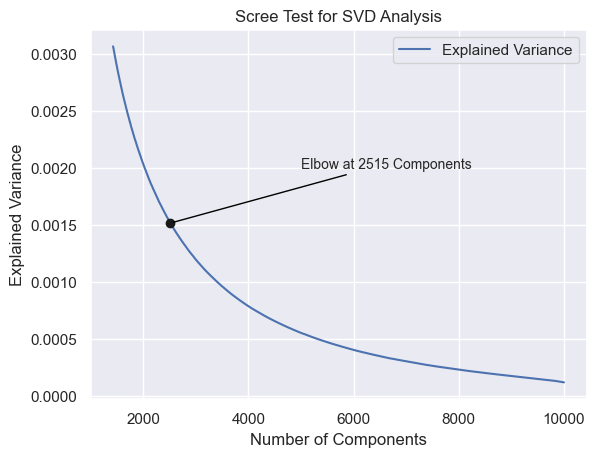

In [49]:
# Obtain Explained Variance
expl_variance = scree_matrix.explained_variance_

# Find Elbow Point
kneedle = KneeLocator(np.arange(ninety_threshold + 1, len(expl_variance)+ 1), 
                      expl_variance[ninety_threshold:], curve='convex', 
                      direction='decreasing')

elbow_location = kneedle.elbow

# Plot Elbow
sns.set_theme()

plt.plot(np.arange(ninety_threshold+1, len(expl_variance)+1),
         expl_variance[ninety_threshold:],
         label = "Explained Variance")

# Add Title and Axis Labels
plt.title("Scree Test for SVD Analysis")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.legend()

# Add Annotation and Point to Show Locatio of Elbow
plt.annotate(f"Elbow at {elbow_location} Components", 
             xy=(elbow_location, expl_variance[elbow_location - 1]),
             xytext=(5000, 0.002),
             arrowprops=dict(arrowstyle="-",
                             color = "black"), fontsize=10)

plt.plot(elbow_location, expl_variance[elbow_location - 1], "ko",
         label = "Elbow Point")

#### Optimized SVD

Having obtained the optimal amount of components, we finally train an SVD 

In [ ]:
# Create Instance of SVD with 2515 Components
svd_opt = TruncatedSVD(n_components=2515, random_state = 70)

# Fit to the Matrix
lat_matrix = svd_opt.fit_transform(vector_df)

In [52]:
# Turn Into DataFrame
svd_df = pd.DataFrame(lat_matrix)

# Add Movie Labels
lat_matr = pd.concat([rs_df.iloc[: , :2], svd_df], axis = 1)

ValueError: DataFrame constructor not properly called!